In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Check GPU
!nvidia-smi

Fri Jul  3 23:35:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install git+https://github.com/d2l-ai/d2l-en # installing d2l
!pip install -U mxnet-cu101mkl==1.6.0  # updating mxnet to at least v1.6

  Cloning https://github.com/d2l-ai/d2l-en to /tmp/pip-req-build-obdl7vr1
  Running command git clone -q https://github.com/d2l-ai/d2l-en /tmp/pip-req-build-obdl7vr1
  Created wheel for d2l: filename=d2l-0.14.0-cp36-none-any.whl size=48950 sha256=df0ea2cef3e2736a910428e18ebd2b760971e3e8dcd516cdf36c50586d88aaa6
  Stored in directory: /tmp/pip-ephem-wheel-cache-mvy8ae8c/wheels/82/6f/b8/8422c7ed664272685e3d139b127f89df39d934704a14b2156c
Successfully built d2l
     |████████████████████████████████| 711.0MB 25kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [4]:
# Verify MXNet detects GPU
from d2l import mxnet as d2l
d2l.try_all_gpus()

[gpu(0)]

In [5]:
import gzip
from collections import defaultdict
import pandas as pd

In [6]:
def readFile(f):
    for l in open(f):
        yield eval(l)

In [7]:
Review_Text = []
Category_ID = []
Summary = []
Helpful = []
Reviewer_ID = []
Review_Hash = []
Review_Time = []

for l in readFile("/content/drive/My Drive/Colab Notebooks/train.json"):
    a = l['reviewText']
    b = l['categoryID']
    c = l['summary']
    d = l['helpful']
    e = l['reviewerID']
    f = l['reviewHash']
    g = l['unixReviewTime']
    Review_Text.append(a)
    Category_ID.append(b)
    Summary.append(c)
    Helpful.append(d)
    Reviewer_ID.append(e)
    Review_Hash.append(f)
    Review_Time.append(g)

In [8]:
df = pd.DataFrame({'Review_Text': Review_Text, 'Summary': Summary, 'Reviewer_ID': Reviewer_ID, 'Helpful': Helpful, 'Review_Hash': Review_Hash,'Review_Time':Review_Time, 'Category_ID': Category_ID})
df.head()

,Review_Text,Summary,Reviewer_ID,Helpful,Review_Hash,Review_Time,Category_ID
0,The model in this picture has them rolled up a...,High Waisted,U490934656,"{'nHelpful': 0, 'outOf': 0}",R798569390,1380153600,0
1,"I love the look of this bra, it is what I want...",Beautiful but size runs small,U714157797,"{'nHelpful': 0, 'outOf': 0}",R436443063,1360195200,0
2,I am not comfortable with wearing my wedding b...,Great Alternative for Nurses,U507366950,"{'nHelpful': 0, 'outOf': 0}",R103439446,1394928000,0
3,Like the look of this top and really looks cut...,One size fits all...Questionable,U307862152,"{'nHelpful': 0, 'outOf': 0}",R486351639,1394409600,0
4,I'm quite small and the XS fits me like a regu...,Great shirt,U742726598,"{'nHelpful': 1, 'outOf': 1}",R508664275,1375142400,0


In [9]:
df['Helpful'] = df['Helpful'].astype('str')
df['Helpful'] = df['Helpful'].str.replace("{","")
df['Helpful'] = df['Helpful'].str.replace("}","")
df['Helpful'] = df['Helpful'].str.replace("'","")
df['Helpful'] = df['Helpful'].str.replace(":","")
df['Helpful'] = df['Helpful'].str.replace(" ","")

In [10]:
df['Helpful'], df['Outof'] = df['Helpful'].str.split(',', 1).str

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.


In [11]:
df.head()

,Review_Text,Summary,Reviewer_ID,Helpful,Review_Hash,Review_Time,Category_ID,Outof
0,The model in this picture has them rolled up a...,High Waisted,U490934656,nHelpful0,R798569390,1380153600,0,outOf0
1,"I love the look of this bra, it is what I want...",Beautiful but size runs small,U714157797,nHelpful0,R436443063,1360195200,0,outOf0
2,I am not comfortable with wearing my wedding b...,Great Alternative for Nurses,U507366950,nHelpful0,R103439446,1394928000,0,outOf0
3,Like the look of this top and really looks cut...,One size fits all...Questionable,U307862152,nHelpful0,R486351639,1394409600,0,outOf0
4,I'm quite small and the XS fits me like a regu...,Great shirt,U742726598,nHelpful1,R508664275,1375142400,0,outOf1


In [12]:
def flatten(TheList):
    listIsNested = True

    while listIsNested:                 #outer loop
        keepChecking = False
        Temp = []

        for element in TheList:         #inner loop
            if isinstance(element,list):
                Temp.extend(element)
                keepChecking = True
            else:
                Temp.append(element)

        listIsNested = keepChecking     #determine if outer loop exits
        TheList = Temp[:]

    return TheList

In [ ]:
# df['Helpful'] = df['Helpful'].apply(lambda x: ",".join(x) if isinstance(x, list) else x)

In [13]:
from mxnet import autograd, gluon, np, npx, init
from mxnet.gluon import nn, rnn
from mxnet.contrib import text
import re
from sklearn.model_selection import train_test_split
npx.set_np()

In [14]:
df['Review_Time'] = df['Review_Time'].astype('str')

In [15]:
df['Full_Text'] = df[['Review_Text','Summary', 'Reviewer_ID', 'Review_Time']].agg(' '.join, axis = 1)
df['Full_Text'] = df['Full_Text'].astype("string")
df.head()

,Review_Text,Summary,Reviewer_ID,Helpful,Review_Hash,Review_Time,Category_ID,Outof,Full_Text
0,The model in this picture has them rolled up a...,High Waisted,U490934656,nHelpful0,R798569390,1380153600,0,outOf0,The model in this picture has them rolled up a...
1,"I love the look of this bra, it is what I want...",Beautiful but size runs small,U714157797,nHelpful0,R436443063,1360195200,0,outOf0,"I love the look of this bra, it is what I want..."
2,I am not comfortable with wearing my wedding b...,Great Alternative for Nurses,U507366950,nHelpful0,R103439446,1394928000,0,outOf0,I am not comfortable with wearing my wedding b...
3,Like the look of this top and really looks cut...,One size fits all...Questionable,U307862152,nHelpful0,R486351639,1394409600,0,outOf0,Like the look of this top and really looks cut...
4,I'm quite small and the XS fits me like a regu...,Great shirt,U742726598,nHelpful1,R508664275,1375142400,0,outOf1,I'm quite small and the XS fits me like a regu...


In [16]:
df['Full_Text'] = df['Full_Text'].str.lower()

In [17]:
# Removing Special Characters
df['Full_Text'] = df['Full_Text'].str.replace(r'[^a-zA-z0-9\s]',"")

In [18]:
def tokenize(lines, token='word'): 
    """Split sentences into word or char tokens."""
    if token == 'word':
        return [line.split(' ') for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type '+token)

In [19]:
df['Full_Text'] = tokenize(df['Full_Text'], token = 'word')

In [20]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
stop.append('i\'m')
stop.append('c')
stop.append('i\'ve')
stop.append('really')
stop.append('also')
stop.append('im')
stop.append('and')
print(stop)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'ea

In [21]:
# Removing stopwords from text
df['Full_Text'] = df['Full_Text'].apply(lambda x: [item for item in x if item not in stop])

In [22]:
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
ps = PorterStemmer()
lmtzr = WordNetLemmatizer()
df['Full_Text'] = df['Full_Text'].apply(lambda x : [ps.stem(y) for y in x])
df['Full_Text'] = df['Full_Text'].apply(lambda x : [lmtzr.lemmatize(y) for y in x])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [23]:
# Removing empty token from text
df['Full_Text'] = df['Full_Text'].apply(lambda x: [item for item in x if item != ''])

In [24]:
df['Full_Text'][0]

['model',
 'pictur',
 'roll',
 'top',
 'actual',
 'high',
 'waist',
 'that',
 'complaint',
 'though',
 'good',
 'qualiti',
 'fit',
 'well',
 '5234',
 '120lb',
 'thick',
 'thigh',
 'love',
 'cant',
 'wait',
 'wear',
 'high',
 'waist',
 'u490934656',
 '1380153600']

In [25]:
df['Category_ID'] = df['Category_ID'].astype('category')

In [26]:
pd.value_counts(df['Category_ID'])

0    141398
1     51416
4      2976
2      2329
3      1881
Name: Category_ID, dtype: int64

In [27]:
# Coverting to numerial values using Vocab

vocab = d2l.Vocab(df['Full_Text'], min_freq=2, reserved_tokens=['<pad>'])

print(list(vocab.token_to_idx.items())[0:10])

[('<unk>', 0), ('<pad>', 1), ('fit', 2), ('wear', 3), ('size', 4), ('great', 5), ('like', 6), ('love', 7), ('look', 8), ('shoe', 9)]


(array([1.1000e+01, 8.0400e+02, 7.6600e+02, 6.8400e+02, 6.8560e+03,
        2.8596e+04, 2.2842e+04, 1.7832e+04, 1.4978e+04, 1.2604e+04,
        1.0770e+04, 9.0980e+03, 7.9740e+03, 6.9350e+03, 6.1490e+03,
        5.4260e+03, 4.7290e+03, 4.0850e+03, 3.6510e+03, 3.2070e+03,
        2.9050e+03, 2.4980e+03, 2.2070e+03, 2.0300e+03, 1.8910e+03,
        1.6800e+03, 1.5240e+03, 1.4080e+03, 1.2160e+03, 1.1330e+03,
        1.0190e+03, 9.3800e+02, 8.0200e+02, 7.6100e+02, 7.0800e+02,
        6.5700e+02, 5.8500e+02, 5.0400e+02, 5.8200e+02]),
 array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
         65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
        130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190,
        195]),
 <a list of 39 Patch objects>)

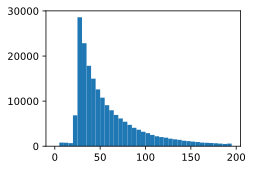

In [ ]:
# Creating a histogram to see the length of healines

d2l.set_figsize((3.5, 2.5))
d2l.plt.hist([len(line) for line in df['Full_Text']], bins=range(0, 200, 5))

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state = 4)

In [ ]:
len(train_df), len(test_df)

(160000, 40000)

In [ ]:
x_train = train_df['Full_Text']
y_train = train_df['Category_ID']
x_test = test_df['Full_Text']
y_test = test_df['Category_ID']

In [ ]:
train_label = list(y_train)
test_label = list(y_test)

In [ ]:
num_steps = 200

train_vocab = np.array([d2l.truncate_pad(vocab[line], num_steps, vocab['<pad>']) for line in x_train])
test_vocab = np.array([d2l.truncate_pad(vocab[line], num_steps, vocab['<pad>']) for line in x_test])

print(f'{train_vocab.shape}, {test_vocab.shape}')

(160000, 200), (40000, 200)


In [ ]:
batch_size = 256
train_iter = d2l.load_array((train_vocab, train_label), batch_size)   
test_iter = d2l.load_array((test_vocab, test_label), batch_size, is_train = False) 

In [ ]:
for X, y in train_iter:
    print('X', X.shape, 'y', y.shape)
    break
'# batches:', len(train_iter)

X (256, 200) y (256,)


('# batches:', 625)

In [ ]:
glove_embedding = text.embedding.create('glove', pretrained_file_name='glove.6B.300d.txt')
embeds = glove_embedding.get_vecs_by_tokens(vocab.idx_to_token)
embeds.shape

(124856, 300)

**MaxPoolCNN**

In [ ]:
class TextCNN(nn.Block):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Dense(5)
        self.pool = nn.GlobalMaxPool1D()
        self.convs = nn.Sequential()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.add(nn.Conv1D(c, k, activation='relu'))

    def forward(self, inputs):
        embeddings = np.concatenate((
            self.embedding(inputs), self.constant_embedding(inputs)), axis=2)
        embeddings = embeddings.transpose(0, 2, 1)
        encoding = np.concatenate([
            np.squeeze(self.pool(conv(embeddings)), axis=-1)
            for conv in self.convs], axis=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs

In [ ]:
embed_size, kernel_sizes, nums_channels = 300, [3, 4, 5], [100, 100, 100]
ctx = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)
net.initialize(init.Xavier(), ctx=ctx)

In [ ]:
net.embedding.weight.set_data(embeds)
net.embedding.collect_params().setattr('grad_req', 'null')

loss 0.405, train acc 0.866, test acc 0.872
5191.6 examples/sec on [gpu(0)]


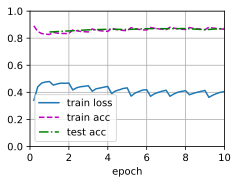

In [ ]:
lr, num_epochs = 0.01, 10
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr, 'wd': 1e-4})
loss = gluon.loss.SoftmaxCrossEntropyLoss()
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, ctx)